## Load packages

In [1]:
import numpy as np
import pandas as pd
import math
from keras import layers
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import keras.backend as K
import tensorflow as tf
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import multilabel_confusion_matrix, classification_report

import geopandas as gpd
%matplotlib inline

Using TensorFlow backend.
/home/magu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/magu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/magu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/magu/.local/lib/python3.6/site-packages/tensorflow/python/framewo

In [2]:
# set number of cores to 8
K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=8, 
                                                   inter_op_parallelism_threads=8)))

## Load dataset

In [31]:
# load processed genetic data from 1000 Genomes
chr1 = np.load('/home/magu/deepmix/data/ALL_DNA_dataset/chr1_1kg_X.npz')
        
# define these for use, print input shape
chr1_V = chr1['V']
X = chr1['G']
X.shape

(5008, 57876, 4)

In [32]:
# Map from sample id to population code
sample_info = pd.read_csv('/home/jsokol/Data/igsr_samples.tsv', delimiter="\t")
pops_to_remove=['ASW','MXL','CEU','PUR','PEL','CLM','ACB'] # +['GIH','ITU','STU']
sample_info = sample_info[~sample_info['Population code'].isin(pops_to_remove)]

sample_to_population = sample_info.set_index('Sample name')['Population code'].dropna().to_dict()
# propagate samples removed above
keep = set()
for i,x in enumerate(np.nditer(chr1['S'])):
    sample_id = chr1['S'][i].decode().split('_')[0] # remove strand label
    if sample_id in sample_to_population:
        keep.add(i)
        
X=X[np.array(list(keep)),:,:]
list(sample_to_population.items())[:5]

[('HG00174', 'FIN'),
 ('HG00179', 'FIN'),
 ('HG00181', 'FIN'),
 ('HG00148', 'GBR'),
 ('HG00150', 'GBR')]

In [33]:
# get geographic info
pop_info=pd.read_csv('/home/jsokol/Data/igsr_population_coordinates.tsv', sep='\t', index_col='Population code')
pop_info=pop_info.loc[~pop_info.index.isnull(),:][['Population longitude', 'Population latitude']]
# pop_info['Population longitude']=(pop_info['Population longitude'] + 180)/360.
# pop_info['Population latitude']=(pop_info['Population latitude'] + 90)/180.
print(pop_info.head(2))
print(pop_info.describe().loc[['min','max']])

                 Population longitude  Population latitude
Population code                                           
ASW                          0.229074             0.697128
YRI                          0.510889             0.541111
     Population longitude  Population latitude
min              0.171545             0.433111
max              0.888000             0.834278


In [35]:
# one hot encode labels
Y = np.zeros((X.shape[0], 2))
for i,ix in enumerate(list(keep)):
    sample_id = chr1['S'][ix].decode().split('_')[0] # remove strand label
    Y[i, 0] = pop_info.loc[sample_to_population[sample_id], 'Population latitude']
    Y[i, 1] = pop_info.loc[sample_to_population[sample_id], 'Population longitude']
Y[np.array([1,353,2043]), :] # show some random samples

array([[0.79159024, 0.49474889],
       [0.72433333, 0.48966667],
       [0.83427778, 0.56925   ]])

In [36]:
[X.shape, Y.shape]

[(3802, 57876, 4), (3802, 2)]

In [37]:
# randomly shuffle the order of the data
randomize = np.random.choice(X.shape[0], X.shape[0], replace=False)
X = X[randomize,:]
Y = Y[randomize,:]

In [38]:
# split data into training and test sets
ntrain=3000
X_train = X[:ntrain,:,:]
X_test = X[ntrain:,:,:]
Y_train = Y[:ntrain,:]
Y_test = Y[ntrain:,:]
print(X_train.shape, Y_train.shape)

(3000, 57876, 4) (3000, 2)


## Build model

In [162]:
def cnn_coord(shape):
    """
    input_shape: The height, width and channels as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]
    """
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(shape=shape)
        
    # First convolutional block
    X = Conv1D(filters=64, kernel_size=512 ,strides=128, padding = 'valid', name = 'conv0')(X_input)
    X = BatchNormalization(axis = -1, name = 'bn0')(X)
    X = Activation('relu')(X)

    # Second convolutional block
    X = Conv1D(64, 64, strides = 4, padding = 'same', name = 'conv1')(X)
    X = BatchNormalization(axis = -1, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1024, activation='tanh')(X)
    X = Dense(1024, activation='relu')(X)
    X = Dense(1024, activation='tanh')(X)
    X = Dense(2, activation='tanh', name='coord')(X)
    #X = Reshape((-1, 2))(X)
    #X = Conv1D(filters=2, kernel_size=2, activation='sigmoid', name='output')(X)
    #X = Flatten()(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='cnn_coord')
    
    return model

## Create and compile the model 

In [163]:
# create model
model = cnn_coord(X_train.shape[1:])

# haversine loss
def haversine(y, y_hat):
    # real haversine takes the arcsin of this:
    return K.sqrt(K.square(K.sin(0.5*np.pi*(y[:,0]-y_hat[:,0]))) + K.cos(np.pi*(y[:,0]-0.5))*K.cos(np.pi*(y_hat[:,0]-0.5))*K.square(K.sin(np.pi*(y[:,1]-y_hat[:,1]))))

# compile model
model.compile(optimizer='adam', loss=haversine)
# summarize model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 57876, 4)          0         
_________________________________________________________________
conv0 (Conv1D)               (None, 449, 64)           131136    
_________________________________________________________________
bn0 (BatchNormalization)     (None, 449, 64)           256       
_________________________________________________________________
activation_19 (Activation)   (None, 449, 64)           0         
_________________________________________________________________
conv1 (Conv1D)               (None, 113, 64)           262208    
_________________________________________________________________
bn1 (BatchNormalization)     (None, 113, 64)           256       
_________________________________________________________________
activation_20 (Activation)   (None, 113, 64)           0         
__________

## Train model

In [164]:
history=model.fit(X_train, Y_train, epochs = 8, batch_size = 128,
                  validation_data=(X_test, Y_test))

Train on 3000 samples, validate on 802 samples
Epoch 1/8
3000/3000 [==============================] - 32s 11ms/step - loss: 0.5402 - val_loss: 0.5395
Epoch 2/8
3000/3000 [==============================] - 30s 10ms/step - loss: 0.5314 - val_loss: 0.5395
Epoch 3/8
3000/3000 [==============================] - 29s 10ms/step - loss: 0.5314 - val_loss: 0.5395
Epoch 4/8
3000/3000 [==============================] - 29s 10ms/step - loss: 0.5314 - val_loss: 0.5395
Epoch 5/8
3000/3000 [==============================] - 29s 10ms/step - loss: 0.5314 - val_loss: 0.5395
Epoch 6/8
3000/3000 [==============================] - 31s 10ms/step - loss: 0.5314 - val_loss: 0.5395
Epoch 7/8
3000/3000 [==============================] - 31s 10ms/step - loss: 0.5314 - val_loss: 0.5395
Epoch 8/8
3000/3000 [==============================] - 30s 10ms/step - loss: 0.5314 - val_loss: 0.5395


## Evaluate model

Text(0.5, 1.0, 'Loss')

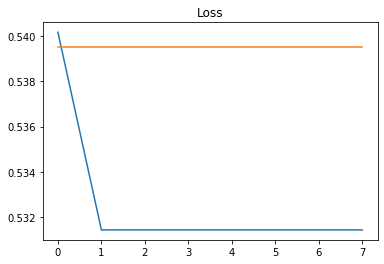

In [165]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss')

In [166]:
test_Y_hat=model.predict(X_test)

In [167]:
test_Y_hat % 1

array([[0.        , 0.23552448],
       [0.        , 0.17259276],
       [0.        , 0.20669931],
       ...,
       [0.        , 0.22887683],
       [0.        , 0.15876818],
       [0.        , 0.23366779]], dtype=float32)

In [168]:
Y_test

array([[0.72175926, 0.82328704],
       [0.55988889, 0.79633333],
       [0.79159024, 0.49474889],
       ...,
       [0.62788889, 0.70161111],
       [0.57474931, 0.45394713],
       [0.5965    , 0.70411111]])

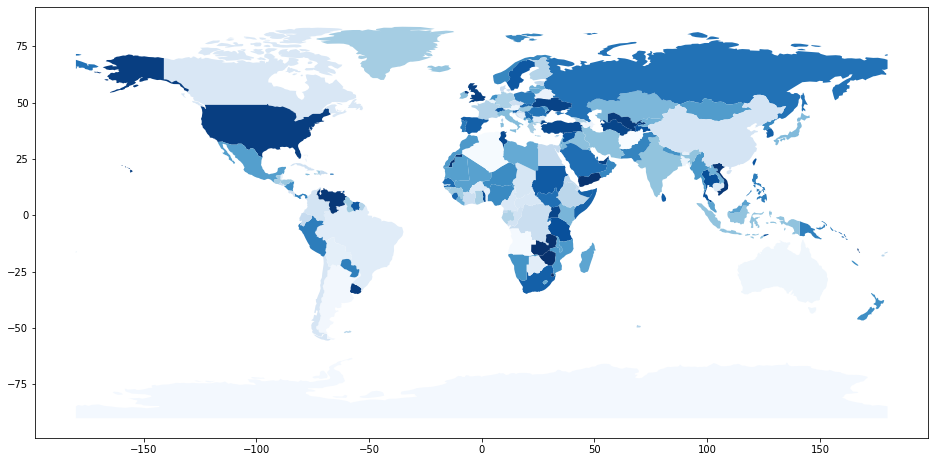

In [154]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# centroids = world.centroid
# centroid_list = pd.concat([world.name, centroids], axis=1)
# Plot the results
base = world.plot(column='name', cmap='Blues', figsize=(16,8))
# centroids.plot(ax = base, marker = 'o', color = 'red', markersize = 5)